# PCA

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.core.debugger import set_trace
from scipy.stats import rankdata
import matplotlib.colors as mcolors
import itertools as it
import functools as ft
import dataclasses
from typing import NamedTuple
from math import cos, sin

## Settings

In [2]:
%matplotlib widget

In [3]:
sns.set()

## Constants 

In [4]:
SLOPE = 2.0
SIZE = 1000

## Utils

In [5]:
def gen_normal(slope, size):
    x = np.random.normal(size=size)
    y = slope * x  + np.random.normal(size=size)
    return x, y

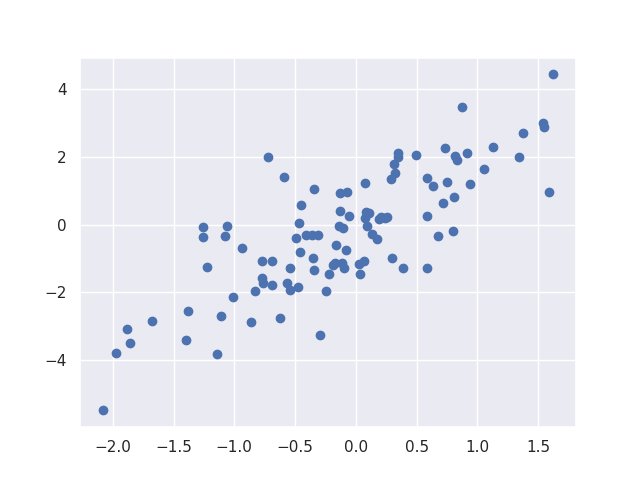

In [6]:
xs, ys = gen_normal(2, 100)
plt.figure()
plt.scatter(xs, ys)


In [7]:
def normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

In [8]:
def gen_data(slope, size, norm=True):
    x, y = gen_normal(slope, size)
    if norm:
         return normalize(x), normalize(y)
    return x, y


In [9]:
def rotate(x: np.ndarray, theta: float) -> np.ndarray:
    rotate_matrix = np.array(
        [
            [cos(theta), -sin(theta)], 
            [sin(theta),  cos(theta)]
        ]
    )
    return rotate_matrix @ x
    

In [10]:
def make_2d(xlim, ylim, xsize, ysize):
    xmin, xmax = xlim
    ymin, ymax = ylim
    x = np.linspace(xmin, xmax, xsize)
    y = np.linspace(ymin, ymax, ysize)
    x, y = np.meshgrid(x, y)
    return np.stack((x, y), axis=-1).reshape((-1, 2))

## Data visualization

In [11]:
data = gen_data(SLOPE, SIZE)

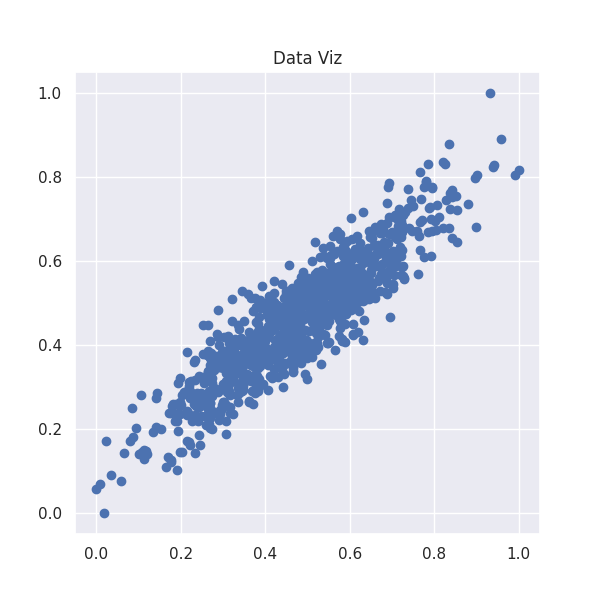

In [13]:
plt.figure(figsize=(6, 6))
plt.scatter(*data)
plt.title("Data Viz")
plt.show()

## PCA Description

### Workflow

1. Compute covariance matrix
2. Compute eigen vectors/values
3. Sort eigen vectors/values based on the eigen values
4. Select k eigen vectors (out of d vectors) as matrix
5. Transform the dataset using the matrix from the previous step


In [14]:
def scale_eigen(eigen_vectors, eigen_values):
    scaled_eig_values = eigen_values / eigen_values.sum()
    st_eigen, nd_eigen = (0.4 * eigen_vectors * scaled_eig_values).T
    return st_eigen, nd_eigen

def translate_vector(xy, vector):
    x, y = xy
    return x + vector[0], y + vector[1]

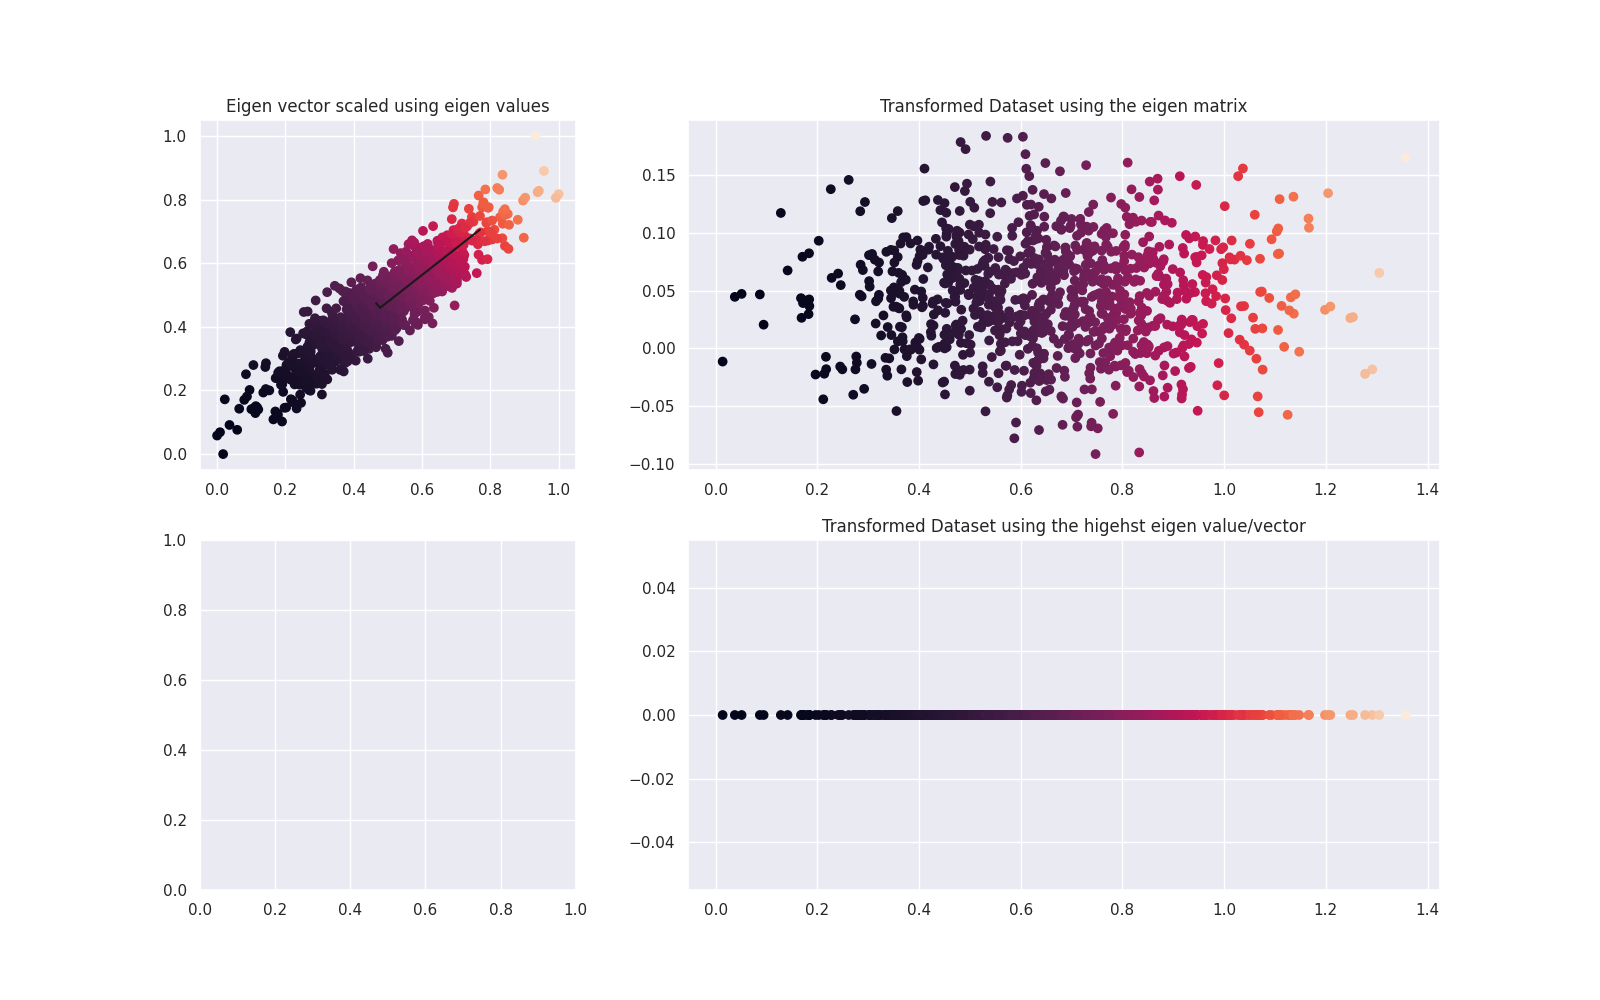

In [15]:
x, y = data
colors = x*x + y*y

x_mean, y_mean = np.mean(x), np.mean(y)

cov = np.cov(x, y)
eig_values, eig_vector = np.linalg.eig(cov)
st_eigen, nd_eigen = scale_eigen(eig_vector, eig_values)
st_eigen = translate_vector((x_mean, y_mean), st_eigen)
nd_eigen = translate_vector((x_mean, y_mean), nd_eigen)


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10), gridspec_kw={'width_ratios': [1, 2]})

ax1.scatter(x, y, c=colors)
ax1.plot([x_mean, st_eigen[0]], [y_mean, st_eigen[1]], c='k')
ax1.plot([x_mean, nd_eigen[0]], [y_mean, nd_eigen[1]], c='k')
ax1.set_title("Eigen vector scaled using eigen values")


max_eigen_value = np.argmax(eig_values)
max_eigen_vector = eig_vector[:, max_eigen_value]


transformed_dataset = eig_vector.T @ np.vstack(data)
reduced_dataset = max_eigen_vector @ np.vstack(data)
ax2.scatter(
    *transformed_dataset, 
    c=colors
)

ax2.set_title("Transformed Dataset using the eigen matrix")

ax4.scatter(
    reduced_dataset,
    np.zeros_like(reduced_dataset),
    c=colors
)
ax4.set_title("Transformed Dataset using the higehst eigen value/vector")
plt.show()
plt.tight_layout()

## Why It works

__The covariance matrix brings the 2d space near the covariance direction, in case there is some covariance__

__Some of the trasformed vector will sufffer only a scalation; those vectors are locate along the covariance direction.__

__The highest scale factor (eigen value) is along the covariance direction__

__The direction and the scalation factor is computed using eigen decomposition.__

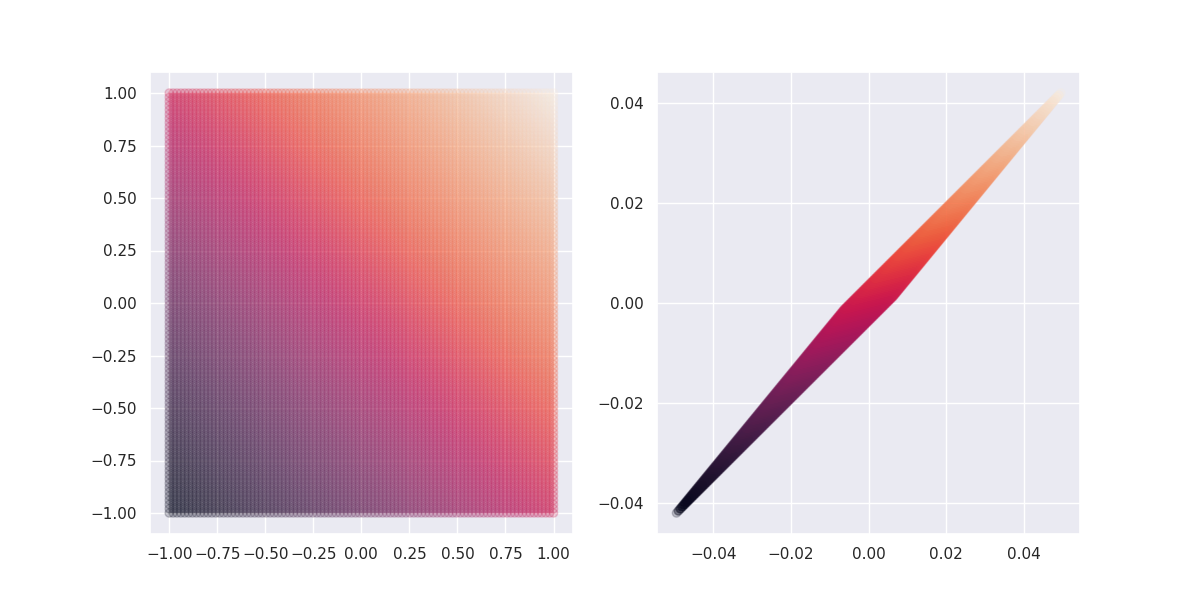

In [16]:
space_2d = make_2d((-1, 1), (-1, 1), 100, 100)
x_space, y_space = space_2d.T
c = x_space + y_space
xc, yc = (space_2d @ cov).T
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.scatter(x_space, y_space, c=c, alpha=0.2)
ax2.scatter(xc, yc, c=c, alpha=0.2)

## Interactive

In [17]:
class InteractiveScatter:
    """Plot the evolution of the 2D EM algorithm"""

    def __init__(self, size=SIZE):
        
        self.data = gen_data(2, size)
        
        self.x, self.y = self.data
        self.mean_x, self.mean_y = np.mean(self.x), np.mean(self.y)
        self.cx, self.cy = self.x-self.mean_x, self.y-self.mean_y
        self.fig, (self.ax1, self.ax2) = plt.subplots(1, 2, figsize=(12, 6))
        self.space_2d = make_2d((-1, 1), (-1, 1), 100, 100)
        self.space_x, self.space_y = self.space_2d.T
        self.space_color = self.space_x+self.space_y
    
    def plot(self, theta):
        self.ax1.clear()
        self.ax2.clear()
        data = rotate(np.vstack((self.cx, self.cy)), np.radians(theta))
        
        self.ax1.set_ylim(-1, 1)
        self.ax1.set_xlim(-1, 1)
        
        xc, yc = (space_2d @ np.cov(*data)).T
            
        self.ax1.scatter(*data, label='no transform')
        self.ax2.scatter(self.space_x, self.space_y, c=self.space_color, alpha=0.1)
        self.ax2.scatter(8*xc, 8*yc, c=self.space_color, alpha=0.6)
        


interactive(children=(FloatSlider(value=180.0, description='theta', max=360.0), Output()), _dom_classes=('widg…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

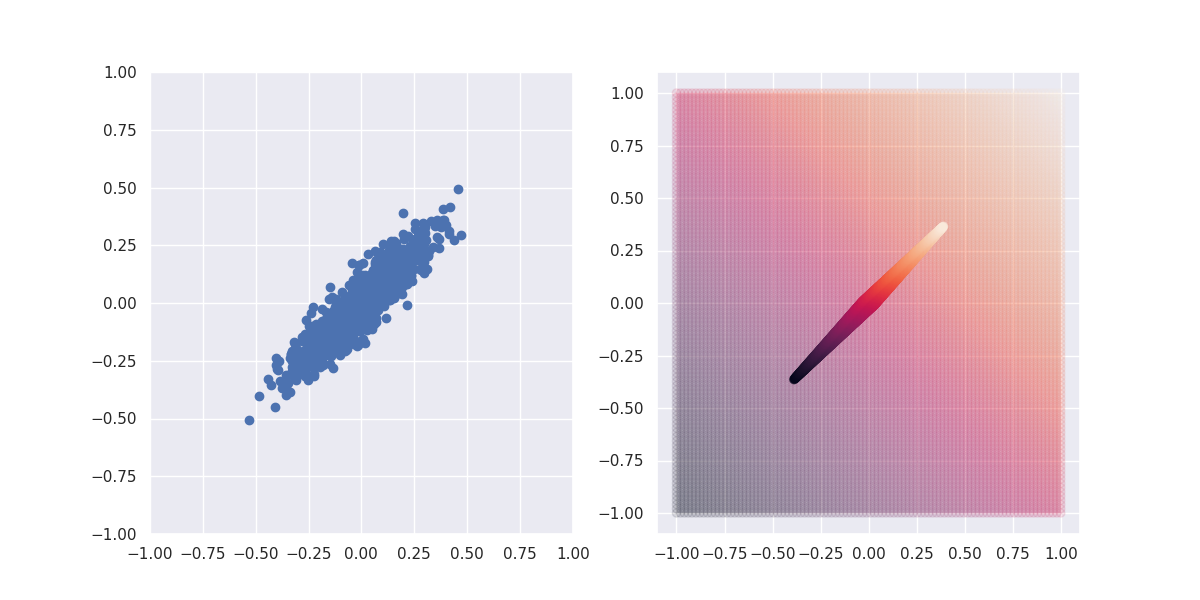

In [18]:
interactive = InteractiveScatter()
widgets.interact(
    interactive.plot, 
    theta=(0, 360, 0.1)
)